# Q6

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [ ]:
import sklearn.model_selection as model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(digits.data, digits.target, train_size=0.7,test_size=0.3, random_state=101)

Part A:

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

class ForwardSelection:
    def __init__(self,train_data,train_label,test_data,test_label):
        self.train = np.array(train_data)
        self.train_label = train_label
        self.test = np.array(test_data)
        self.test_label = test_label
    def forward(self):
        selected_features_index = []
        acc_list = []
        for j in range(len(self.train[0])):
            max_acc = float("-inf")
            selected_index = 0
            for i in range(len(self.train[0])):
                if i in selected_features_index:
                    continue
                selected_features_index.append(i)
                
                X = self.train[:, selected_features_index]
                clf = MultinomialNB()
                clf.fit(X, self.train_label)
                predicts = clf.predict(self.test[:, selected_features_index])
                acc = accuracy_score(self.test_label, predicts)
                
                if acc > max_acc:
                    max_acc = acc
                    selected_index = i
                
                selected_features_index.pop()
            selected_features_index.append(selected_index)
            acc_list.append(max_acc)
        return selected_features_index,acc_list

In [ ]:
f = ForwardSelection(X_train,y_train,X_test,y_test)
selected,acc_list = f.forward()

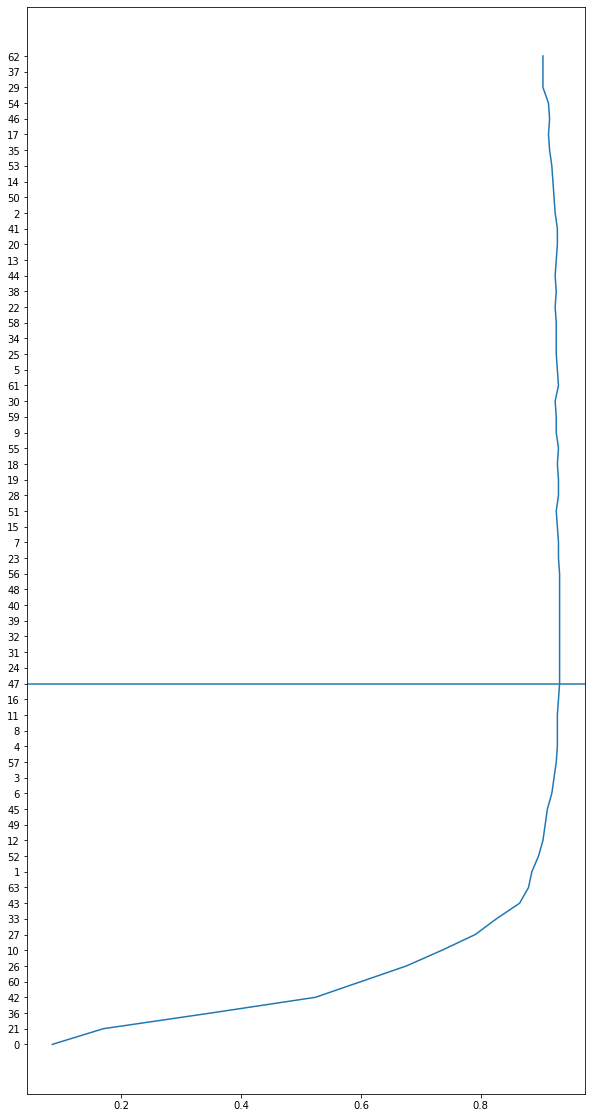

In [ ]:
fig, ax = plt.subplots()

fig.set_figwidth(10)
fig.set_figheight(20)
ax.plot(acc_list, range(1, 65))
ax.axhline(y = 1 + np.argmax(acc_list), linestyle = '-')
ax.set_yticks(range(1, 65))
ax.set_yticklabels(selected)
plt.show()

Part B:

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
class BackwardSelection:
    def __init__(self,train_data,train_label,test_data,test_label):
        self.train = np.array(train_data)
        self.train_label = train_label
        self.test = np.array(test_data)
        self.test_label = test_label
    def backward(self):
        removed_features_index = []
        acc_list = []
        all_features = range(64)
        for j in range(len(self.train[0])-1):
            max_acc = float("-inf")
            selected_index = 0
            for i in range(len(self.train[0])):
                if i in removed_features_index:
                    continue
                removed_features_index.append(i)
                
                selected_features = np.array(list(set(all_features) - set(removed_features_index)))
                X = self.train[:, selected_features]
                clf = MultinomialNB()
                clf.fit(X, self.train_label)
                predicts = clf.predict(self.test[:, selected_features])
                acc = accuracy_score(self.test_label, predicts)
                
                if acc > max_acc:
                    max_acc = acc
                    selected_index = i
                
                removed_features_index.pop()
            removed_features_index.append(selected_index)
            acc_list.append(max_acc)
        return removed_features_index,acc_list

In [ ]:
b = BackwardSelection(X_train,y_train,X_test,y_test)
removed,acc_list = b.backward()

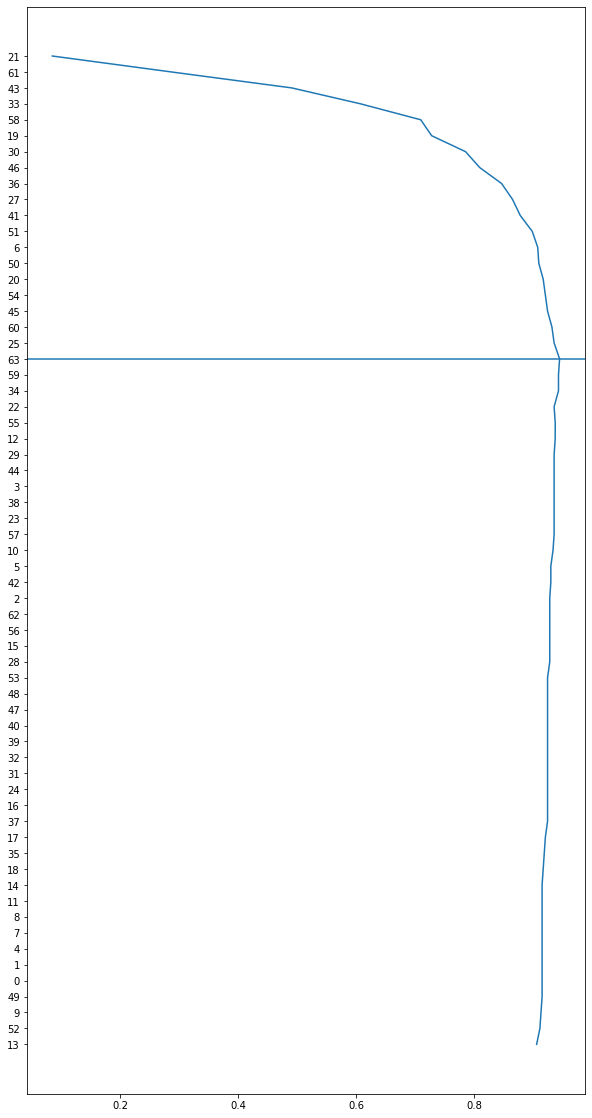

In [ ]:
fig, ax = plt.subplots()

fig.set_figwidth(10)
fig.set_figheight(20)
ax.plot(acc_list, range(1, 64))
ax.axhline(y = 1 + np.argmax(acc_list), linestyle = '-')
ax.set_yticks(range(1, 64))
ax.set_yticklabels(removed)
plt.show()

# Q7

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [ ]:
def Si(data, labels):
    class_data = [[] for i in range(10)]
    result = [0 for i in range(10)]
    for i in range(len(data)):
        class_data[labels[i]].append(data[i])
    for i in range(10):
        mi = np.mean(np.array(class_data[i]), axis=0)
        diff = class_data[i] - mi
        for vector in diff:
            result[i] += np.matmul(vector.reshape(len(data[0]),1), vector.reshape(len(data[0]),1).T)    
    return result
        
def Sw(data, labels):
    Sis = Si(data, labels)
    result = Sis[0]
    for i in range(1, 10):
        result += Sis[i]
    return result

def Sb(data, labels):
    ovarall_mean = np.mean(data, axis=0)
    class_data = [[] for i in range(10)]
    result = 0
    for i in range(len(data)):
        class_data[labels[i]].append(data[i])
    for i in range(10):
        mi = np.mean(np.array(class_data[i]), axis=0)
        diff = mi - ovarall_mean
        result += len(class_data[i]) * (np.matmul(((diff).reshape(1, len(data[0])).T), (diff).reshape(1, len(data[0]))))
    return result

def LDA(data, labels):
    S_B = Sb(data, labels)
    S_W = Sw(data, labels)
    
    for i in range(64):
        S_B[i][i] += 0.01
        S_W[i][i] += 0.01
    
    eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
    eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)
    w = np.hstack((eig_pairs[0][1].reshape(64,1), eig_pairs[1][1].reshape(64,1)))
    return w

In [ ]:
w = LDA(digits.data, digits.target)

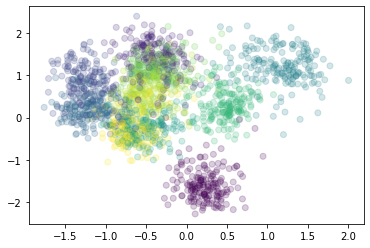

In [ ]:
X_lda = digits.data.dot(w)

plt.scatter(X_lda[:, 0], X_lda[:, 1], alpha=0.2, c=digits.target, cmap='viridis')
plt.show()

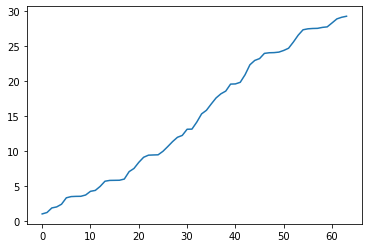

In [ ]:
seprability_measure = []
for i in range(1, 65):
    S_B = Sb(digits.data[:, : i], digits.target)
    S_W = Sw(digits.data[:, : i], digits.target)

    for i in range(i):
        S_B[i][i] += 0.01
        S_W[i][i] += 0.01

    seprability_measure.append(np.trace(np.linalg.inv(S_W).dot(S_B)))
    
plt.plot(range(64), seprability_measure)
plt.show()

# Q8

Part A

In [1]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)

In [4]:
def PCATransformer(X, component):
    X_meaned = X - np.mean(X , axis = 0)
    cov_mat = np.cov(X_meaned , rowvar = False)
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
    eigenvector_subset = sorted_eigenvectors[:,0:component]
    projected = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()
    return projected
projected = PCATransformer(faces.data,2)

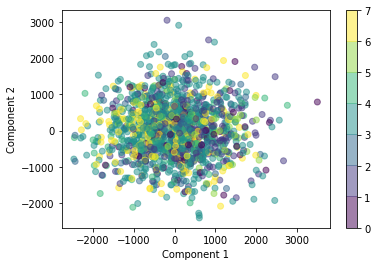

In [5]:
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.scatter(projected[:, 0], projected[:, 1], alpha=0.5, cmap=plt.cm.get_cmap('viridis', 7), c=faces.target)
plt.colorbar()
plt.show()

Part B:

In [6]:
X_meaned = faces.data - np.mean(faces.data , axis = 0)
cov_mat = np.cov(X_meaned , rowvar = False)
eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
sorted_index = np.argsort(eigen_values)[::-1]
sorted_eigenvalue = eigen_values[sorted_index]

eig_vals_total = sum(sorted_eigenvalue)
explained_variance = [(i / eig_vals_total)*100 for i in sorted_eigenvalue]
explained_variance = np.round(explained_variance, 2)
cum_explained_variance = np.cumsum(explained_variance)

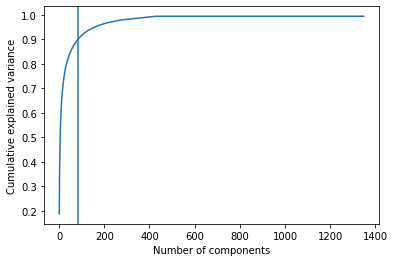

In [ ]:
component_with_morethan90 = 0
for i in range(len(cum_explained_variance)):
  if cum_explained_variance[i] >= 90:
    component_with_morethan90 = i
    break

plt.plot(np.arange(1, 1349), (cum_explained_variance/100)[:1348])
plt.axvline(x=component_with_morethan90)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

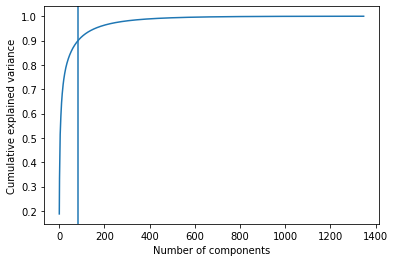

In [16]:
pca = PCA().fit(faces.data)

component_with_morethan90 = 0
for i in range(len(np.cumsum(pca.explained_variance_ratio_))):
  if np.cumsum(pca.explained_variance_ratio_)[i] >= 0.9:
    component_with_morethan90 = i
    break

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axvline(x=component_with_morethan90)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()

Part C

In [21]:
def plot_faces(images, n_row, n_col):
    plt.figure(figsize=(1.5 * n_col, 2.2 * n_row))
    plt.subplots_adjust(0.6, 0.5, 1.5, 1.5)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((62, 47)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())
    plt.tight_layout()
    plt.show()
    

Xmean = np.mean(faces.data,axis=0).reshape(1, faces.data.shape[1])

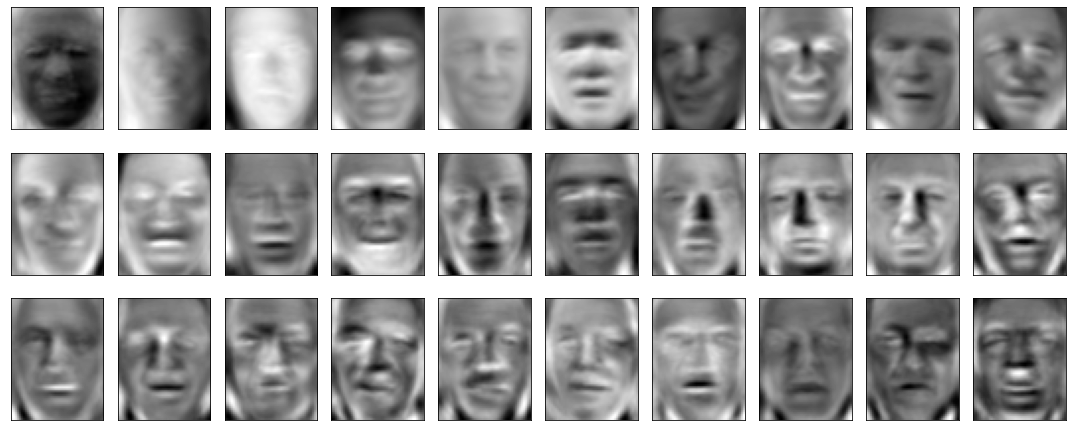

In [24]:
n_components = 30
pca = PCA(n_components=30, svd_solver='randomized').fit(faces.data)
eigenfaces = pca.components_
plot_faces(eigenfaces[:30], 3, 10)

Part D:

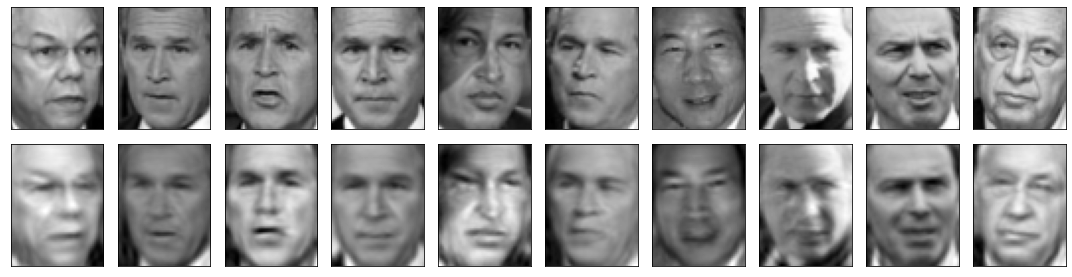

In [35]:
pca = PCA(n_components=120, svd_solver='randomized').fit(faces.data)
X_test_pca = pca.transform(faces.data[:10])
X_test_rec = pca.inverse_transform(X_test_pca)
plot_faces(np.concatenate((faces.data[:10], X_test_rec[:10]), axis=0), 2, 10)